# HATLAS-SGP master catalogue
## Preparation of ATLAS/VST data

ATLAS/VST catalogue: the catalogue comes from `dmu0_ATLAS`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The aperture corrected aperture magnitude in each band (2")
- The Petrosian magnitude to be used as total magnitude (no “auto” magnitude is provided).

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "atlas_ra"
DEC_COL = "atlas_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'sourceID': "atlas_id",
        'ra': "atlas_ra",
        'dec': "atlas_dec",
        'pStar':  "atlas_stellarity",
        'uAperMag3': "m_ap_atlas_u", 
        'uAperMag3Err': "merr_ap_atlas_u", 
        'uPetroMag': "m_atlas_u", 
        'uPetroMagErr': "merr_atlas_u",  
        'ulAperMag3': "m_ap_atlas_ul", 
        'ulAperMag3Err': "merr_ap_atlas_ul", 
        'ulPetroMag': "m_atlas_ul", 
        'ulPetroMagErr': "merr_atlas_ul", 
        'gAperMag3': "m_ap_atlas_g", 
        'gAperMag3Err': "merr_ap_atlas_g", 
        'gPetroMag': "m_atlas_g", 
        'gPetroMagErr': "merr_atlas_g",     
        'rAperMag3': "m_ap_atlas_r", 
        'rAperMag3Err': "merr_ap_atlas_r", 
        'rPetroMag': "m_atlas_r", 
        'rPetroMagErr': "merr_atlas_r",     
        'iAperMag3': "m_ap_atlas_i", 
        'iAperMag3Err': "merr_ap_atlas_i", 
        'iPetroMag': "m_atlas_i", 
        'iPetroMagErr': "merr_atlas_i",    
        'zAperMag3': "m_ap_atlas_z", 
        'zAperMag3Err': "merr_ap_atlas_z", 
        'zPetroMag': "m_atlas_z", 
        'zPetroMagErr': "merr_atlas_z", 

    })


catalogue = Table.read("../../dmu0/dmu0_ATLAS/data/ATLAS_HATLAS-SGP.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        # Large negative numbers are used for missing values.
        catalogue[col][catalogue[col] <= 0] = np.nan
        catalogue[errcol][catalogue[errcol] <= 0] = np.nan  
        

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [6]:
catalogue[:10].show_in_notebook()

idx,atlas_id,atlas_ra,atlas_dec,atlas_stellarity,m_ap_atlas_u,merr_ap_atlas_u,m_atlas_u,merr_atlas_u,m_ap_atlas_ul,merr_ap_atlas_ul,m_atlas_ul,merr_atlas_ul,m_ap_atlas_g,merr_ap_atlas_g,m_atlas_g,merr_atlas_g,m_ap_atlas_r,merr_ap_atlas_r,m_atlas_r,merr_atlas_r,m_ap_atlas_i,merr_ap_atlas_i,m_atlas_i,merr_atlas_i,m_ap_atlas_z,merr_ap_atlas_z,m_atlas_z,merr_atlas_z,f_ap_atlas_u,ferr_ap_atlas_u,f_atlas_u,ferr_atlas_u,flag_atlas_u,f_ap_atlas_ul,ferr_ap_atlas_ul,f_atlas_ul,ferr_atlas_ul,flag_atlas_ul,f_ap_atlas_g,ferr_ap_atlas_g,f_atlas_g,ferr_atlas_g,flag_atlas_g,f_ap_atlas_r,ferr_ap_atlas_r,f_atlas_r,ferr_atlas_r,flag_atlas_r,f_ap_atlas_i,ferr_ap_atlas_i,f_atlas_i,ferr_atlas_i,flag_atlas_i,f_ap_atlas_z,ferr_ap_atlas_z,f_atlas_z,ferr_atlas_z,flag_atlas_z
0,730144460444,22.7457438512,-31.0597494285,0.99999899,18.537502,0.013663703,18.679255,0.024131361,18.540213,0.014982387,18.671234,0.029455535,17.813747,0.0032649424,17.850933,0.0036543449,17.354736,0.0030359742,17.377827,0.0035660265,17.192034,0.0040192781,17.225304,0.0061157038,17.015871,0.0090917163,17.082668,0.017598459,139.636578885,1.75728941658,122.545678296,2.72367633039,False,139.28835199,1.92208013785,123.454350794,3.34926102195,False,271.957600055,0.817809975878,262.800870836,0.884528873447,False,415.054952217,1.16059142266,406.320935755,1.33453339592,False,482.154694914,1.78488457656,467.604196424,2.633907526,False,567.089491983,4.74868274193,533.252376981,8.64337032496,False
1,730144460445,22.7233211913,-31.0519613319,0.050000001,20.451843,0.054901563,21.047724,0.097468987,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,23.9476443638,1.21094157124,13.8328096259,1.24180250754,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
2,730144460446,22.7856996673,-31.0476899699,0.050000001,19.673891,0.029891161,20.171867,0.046140529,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,49.0279348138,1.34977712505,30.9922566624,1.3170778602,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
3,730144460447,22.750519051,-31.0435217188,0.050000001,20.439713,0.054509021,21.035053,0.09726382,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,24.2166909832,1.21579082614,13.9951900366,1.25373515097,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
4,730144460737,22.7232689813,-30.937088957,0.0030674851,nan,nan,nan,nan,23.223457,0.79409862,24.199713,2.1117728,23.014698,0.15025359,22.475542,0.15583485,22.75458,0.18118025,22.823257,0.17119166,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,1.86473533338,1.36385223999,0.758778121479,1.4758345454,False,2.26006432484,0.312767297388,3.7134980483,0.532995407905,False,2.87189131323,0.479241627776,2.69585916266,0.425065133831,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
5,730144460738,22.7196088838,-30.937063864,9.5258065e-06,nan,nan,nan,nan,nan,nan,16.272659,0.17472713,22.27787,0.077971511,21.696466,0.12816493,21.301308,0.049741138,20.782869,0.13223615,20.759392,0.068090506,20.30797,0.1355512,20.331091,0.15290156,20.326199,0.15353543,nan,nan,nan,nan,False,nan,nan,1124.44029391,180.9557649,False,4.4550440238,0.319936382875,7.61050717963,0.898376710353,False,10.9515805049,0.501727836674,17.654377143,2.15019712321,False,18.0402769317,1.13137203979,27.3408492302,3.41343035807,False,26.7647751968,3.76921747907,26.8856412931,3.80193501762,False
6,730144460739,22.7675309726,-30.9357658447,0.00017140902,nan,nan,nan,nan,26.723186,19.918322,21.20163,0.13723344,22.784761,0.12357213,22.492748,0.14345652,22.09502,0.1011068,21.945015,0.18292286,21.744411,0.16781555,21.764706,0.15280862,nan,nan,nan,nan,nan,nan,nan,nan,False,0.0742549824877,1.36224125604,12.0046084667,1.51734252622,False,2.79315862357,0.317900940422,3.65511293288,0.482943996213,False,5.27220149579,0.490962

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['merr_ap_atlas_g', 
             'merr_ap_atlas_r', 
             'merr_ap_atlas_i', 
             'merr_ap_atlas_u', 
             'merr_ap_atlas_ul', 
             'merr_ap_atlas_z']
FLAG_NAME = 'atlas_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 7937203 sources.
The cleaned catalogue has 7562634 sources (374569 removed).
The cleaned catalogue has 362887 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_SGP.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

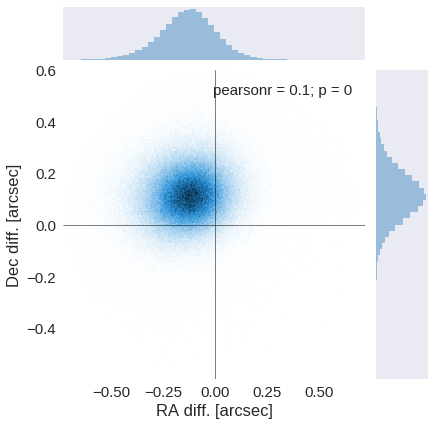

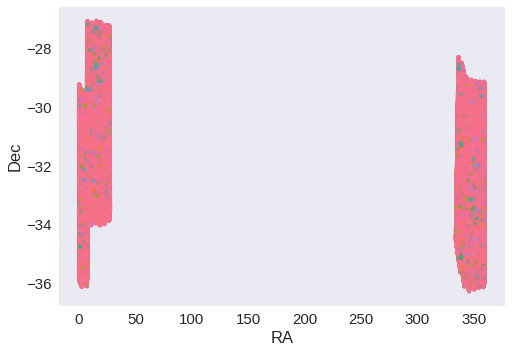

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.12983922197875586 arcsec
Dec correction: -0.11415334424285106 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

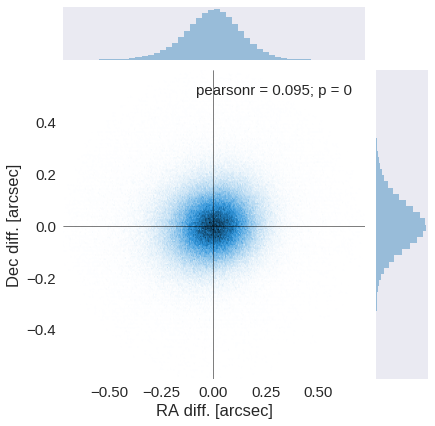

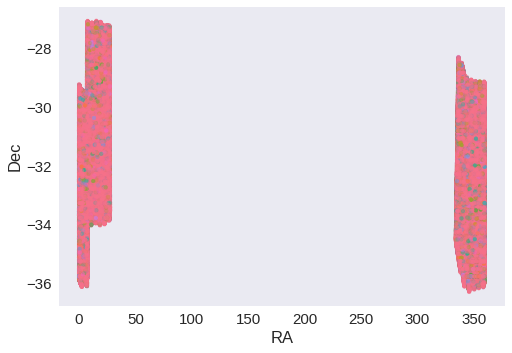

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "atlas_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

754069 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/ATLAS.fits".format(OUT_DIR), overwrite=True)